# CelebAデータセット

### 読み込む

In [ ]:
import torchvision
image_path='../第12章_ニューラルネットワークの訓練をPyTorchで並列化する'
celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', download=False, target_type='attr')
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', download=False, target_type='attr')
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', download=False, target_type='attr')
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

### データ拡張

* 画像を矩形に切り抜く。
* 水平方向に反転させる。
* コントラストを調整する。
* 明度を調整する。
* 画像を中心でくり抜き、元のサイズ(218x178)に戻す。

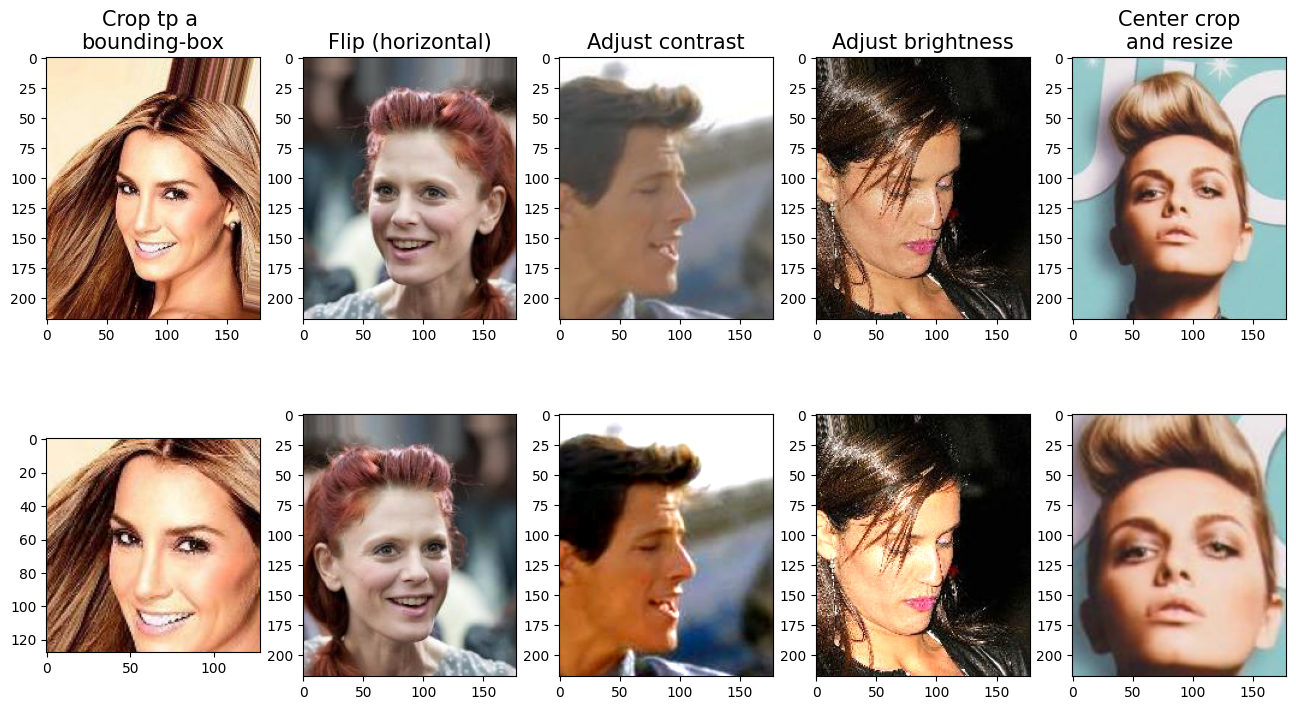

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
fig = plt.figure(figsize=(16, 8.5))
# 列１：画像を矩形に切り抜く
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop tp a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)
# 列２：水平方向に反転させる
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)
# 列３：コントラストを調整する
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust contrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2.0) # コントラストを2倍に調整
ax.imshow(img_adj_contrast)
# 列４：明度を調整する
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3) # 明度を1.3倍に調整
ax.imshow(img_adj_brightness)
# 列５：画像を中心でくり抜き、元のサイズ(218x178)に戻す。
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178]) # 70%のサイズに切り抜く
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178)) # 元のサイズに戻す
ax.imshow(img_resized)
plt.show()

全ての変換をランダムに適用することもでき、モデルの訓練時のデータ拡張には、この方法が推奨される。例えば、一様分布の乱数を使って、
* ランダムな矩形（左上隅の座標をランダムに選択する）を画像からくり抜く。
* 水平軸または垂直軸に沿って（0.5の確率で）画像をランダムに反転させる。
* 画像のコントラストをランダムに変化させる。
さらにこれらの変換からなるパイプラインを作成できる。

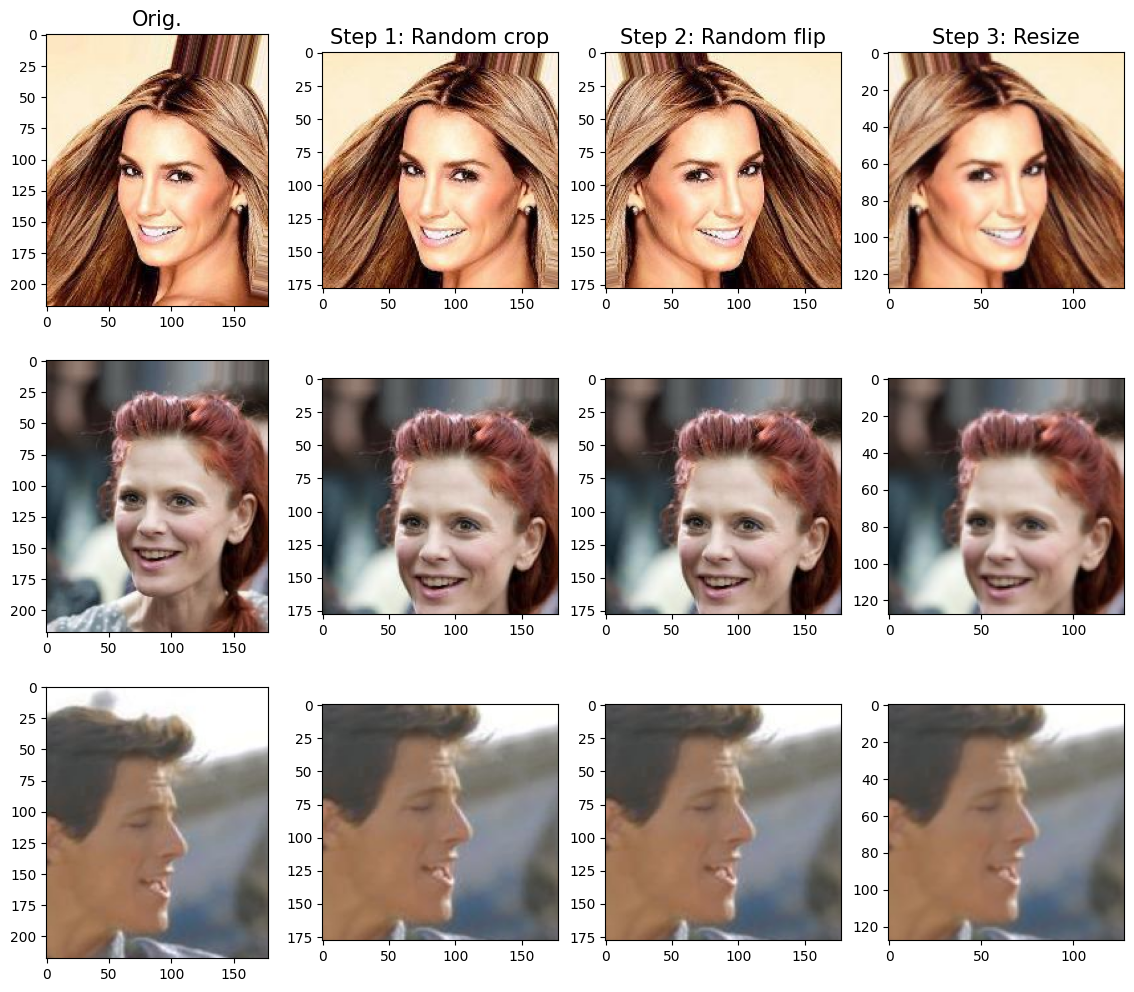

In [ ]:
import torch
torch.manual_seed(1)
fig = plt.figure(figsize=(14, 12))
for i, (img, attr) in enumerate(celeba_train_dataset):
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(img)
    if i == 0:
        ax.set_title('Orig.', size=15)
    
    ax = fig.add_subplot(3, 4, i*4+2)
    img_transform = transforms.Compose([transforms.RandomCrop((178, 178))])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)
    
    ax = fig.add_subplot(3, 4, i*4+3)
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)
    
    ax = fig.add_subplot(3, 4, i*4+4)
    img_resized = transforms.functional.resize(img_flip, size=(128, 128))
    ax.imshow(img_resized)
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)
    if i == 2:
        break

plt.show()

In [ ]:
# 笑顔ラベルの抽出
get_smile = lambda attr: attr[31]

In [ ]:
# ランダムに切り取った後、ランダムに反転させ、さらにサイズを64x64に変更する。
transform_smile = transforms.Compose([
    transforms.RandomCrop((178, 178)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [ ]:
# 検証データ・テストデータ用の変換
transform = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

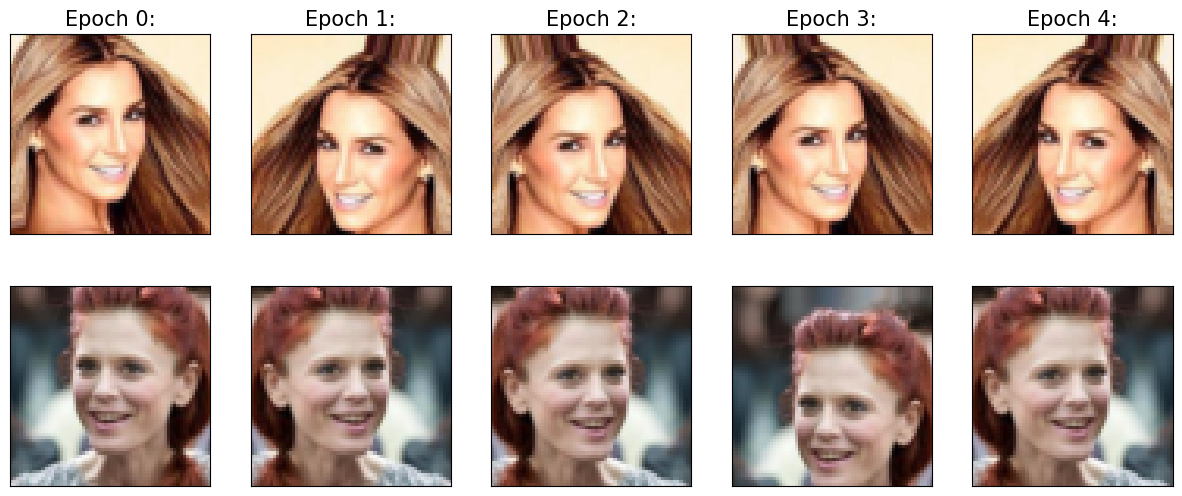

In [ ]:
from torch.utils.data import DataLoader
# 変換には学習用に用意したtransform_smileを使用
celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', download=False, target_type='attr', transform=transform_smile, target_transform=get_smile)
torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)
fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))  # チャンネルを最後に移動

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j+6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))  # チャンネルを最後に移動

plt.show()

In [ ]:
#　変換には検証・テスト用に用意したtransformを使用
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', download=False, target_type='attr', transform=transform, target_transform=get_smile)
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', download=False, target_type='attr', transform=transform, target_transform=get_smile)

In [ ]:
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

Train set: 162770
Validation set: 19867
Test set: 19962


In [ ]:
# データセットのサイズを小さくする
from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))

Train set: 16000
Validation set: 1000


In [ ]:
# データローダー
batch_size = 32
torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size=batch_size, shuffle=False)

## CNN笑顔分類器を訓練

In [ ]:
import torch.nn as nn
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

In [ ]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

In [ ]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256])

In [ ]:
model.add_module('fc1', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 1])

In [ ]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]  # 出力を1次元にする
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred > 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred > 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: '
              f'{accuracy_hist_train[epoch]:.4f} val accuracy: '
              f'{accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [ ]:
torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5116 val accuracy: 0.5540
Epoch 2 accuracy: 0.5324 val accuracy: 0.5740
Epoch 3 accuracy: 0.5526 val accuracy: 0.5940
Epoch 4 accuracy: 0.6044 val accuracy: 0.6070
Epoch 5 accuracy: 0.6326 val accuracy: 0.6180
Epoch 6 accuracy: 0.6494 val accuracy: 0.6270
Epoch 7 accuracy: 0.6581 val accuracy: 0.6180
Epoch 8 accuracy: 0.6737 val accuracy: 0.6420
Epoch 9 accuracy: 0.6819 val accuracy: 0.6140
Epoch 10 accuracy: 0.6944 val accuracy: 0.7110
Epoch 11 accuracy: 0.7078 val accuracy: 0.6200
Epoch 12 accuracy: 0.7295 val accuracy: 0.7450
Epoch 13 accuracy: 0.7627 val accuracy: 0.7940
Epoch 14 accuracy: 0.7896 val accuracy: 0.7660
Epoch 15 accuracy: 0.8133 val accuracy: 0.8370
Epoch 16 accuracy: 0.8254 val accuracy: 0.8510
Epoch 17 accuracy: 0.8348 val accuracy: 0.8650
Epoch 18 accuracy: 0.8422 val accuracy: 0.8580
Epoch 19 accuracy: 0.8521 val accuracy: 0.8710
Epoch 20 accuracy: 0.8536 val accuracy: 0.8630
Epoch 21 accuracy: 0.8535 val accuracy: 0.8870
Epoch 22 accuracy: 0.8

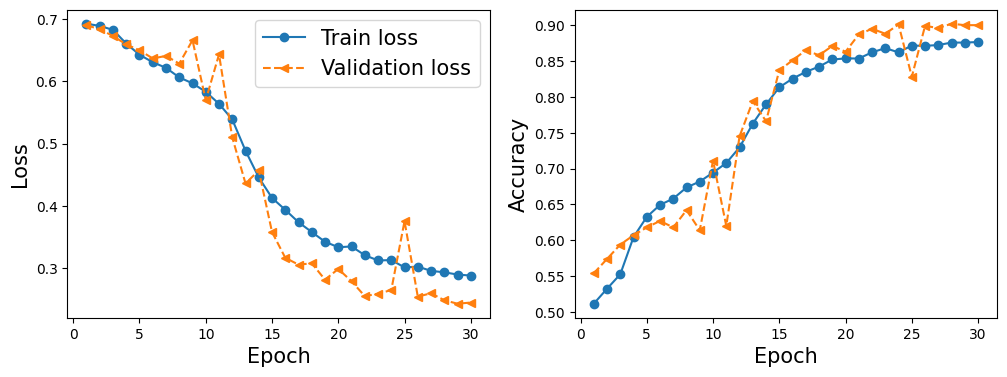

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [ ]:
accuracy_test = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred > 0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()

accuracy_test /= len(test_dl.dataset)
print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.9029


IndexError: index 10 is out of bounds for dimension 0 with size 6

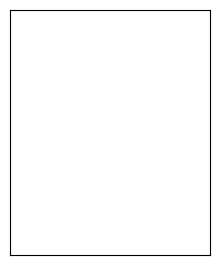

In [ ]:
pred = model(x_batch)[:, 0] * 100
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))  # チャンネルを最後に移動
    if y_batch[j] == 1:
        label = 'Smile'
    else:
        label = 'Not smile'
    ax.text(0.5, -0.15, f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%',
            size=16, horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
plt.show()